# SET UP

### IMPORT LIBRARIES

In [3]:
import argparse
import ast
import csv
import itertools
import json
import os
import re

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.linalg as la
from netgraph import InteractiveGraph, Graph
from numpy.linalg import eig
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm

import quantecon as qe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### DEFINE GLOBAL VARIABLE

In [15]:
def getboundaryofamperfromregion(data):
    amperboundaries = {}
    for i in data.index:
        geom = data.at[i, "geometry"]
        pv_name = data.at[i, 'pv_tn']
        re_name = data.at[i, "re_royin"]
        ap_name = data.at[i, 'ap_tn'] if 'ap_tn' in data else ""

        if geom.geom_type == 'Polygon':
            # print("This geometry is a Polygon")
            coordinates_list = list(geom.exterior.coords)
            coordinates_list = [list(coordinate) for coordinate in coordinates_list]

        elif geom.geom_type == 'MultiPolygon':
            polygon_list = list(geom.geoms)  
            coordinates_list = []
            for polygon in polygon_list:
                polygon_coordinates_list = list(polygon.exterior.coords)
                coordinates_list += [list(coordinate) for coordinate in polygon_coordinates_list]

        amperkey = (ap_name, pv_name)
        centroid = geom.centroid
        amperboundaries[amperkey] = {'cor': coordinates_list, 'centroid':centroid}

    return amperboundaries

with open('data_gen/allprovincesTH.txt', 'r', encoding='utf-8') as file:
    allprovinces = []
    for line in file:
        allprovinces.append(line.strip())

central = gpd.read_file('data_base/boundary/query-2.geojson')
east = gpd.read_file('data_base/boundary/query-3.geojson')
north = gpd.read_file('data_base/boundary/query-4.geojson')
south = gpd.read_file('data_base/boundary/query-5.geojson')
northeast = gpd.read_file('data_base/boundary/query-6.geojson')
west = gpd.read_file('data_base/boundary/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

central_amperboundaries = getboundaryofamperfromregion(central)
east_amperboundaries = getboundaryofamperfromregion(east)
north_amperboundaries = getboundaryofamperfromregion(north)
south_amperboundaries = getboundaryofamperfromregion(south)
northeast_amperboundaries = getboundaryofamperfromregion(northeast)
west_amperboundaries = getboundaryofamperfromregion(west)

all_amperboundaries = {**central_amperboundaries, **east_amperboundaries, **north_amperboundaries, **south_amperboundaries, **northeast_amperboundaries, **west_amperboundaries}
allampers = list(all_amperboundaries.keys())

DICT_amper2int = {item: index for index, item in enumerate(allampers)}

In [ ]:
rivers = gpd.read_file("data_base/road/2022-08-17-filter.geojson")

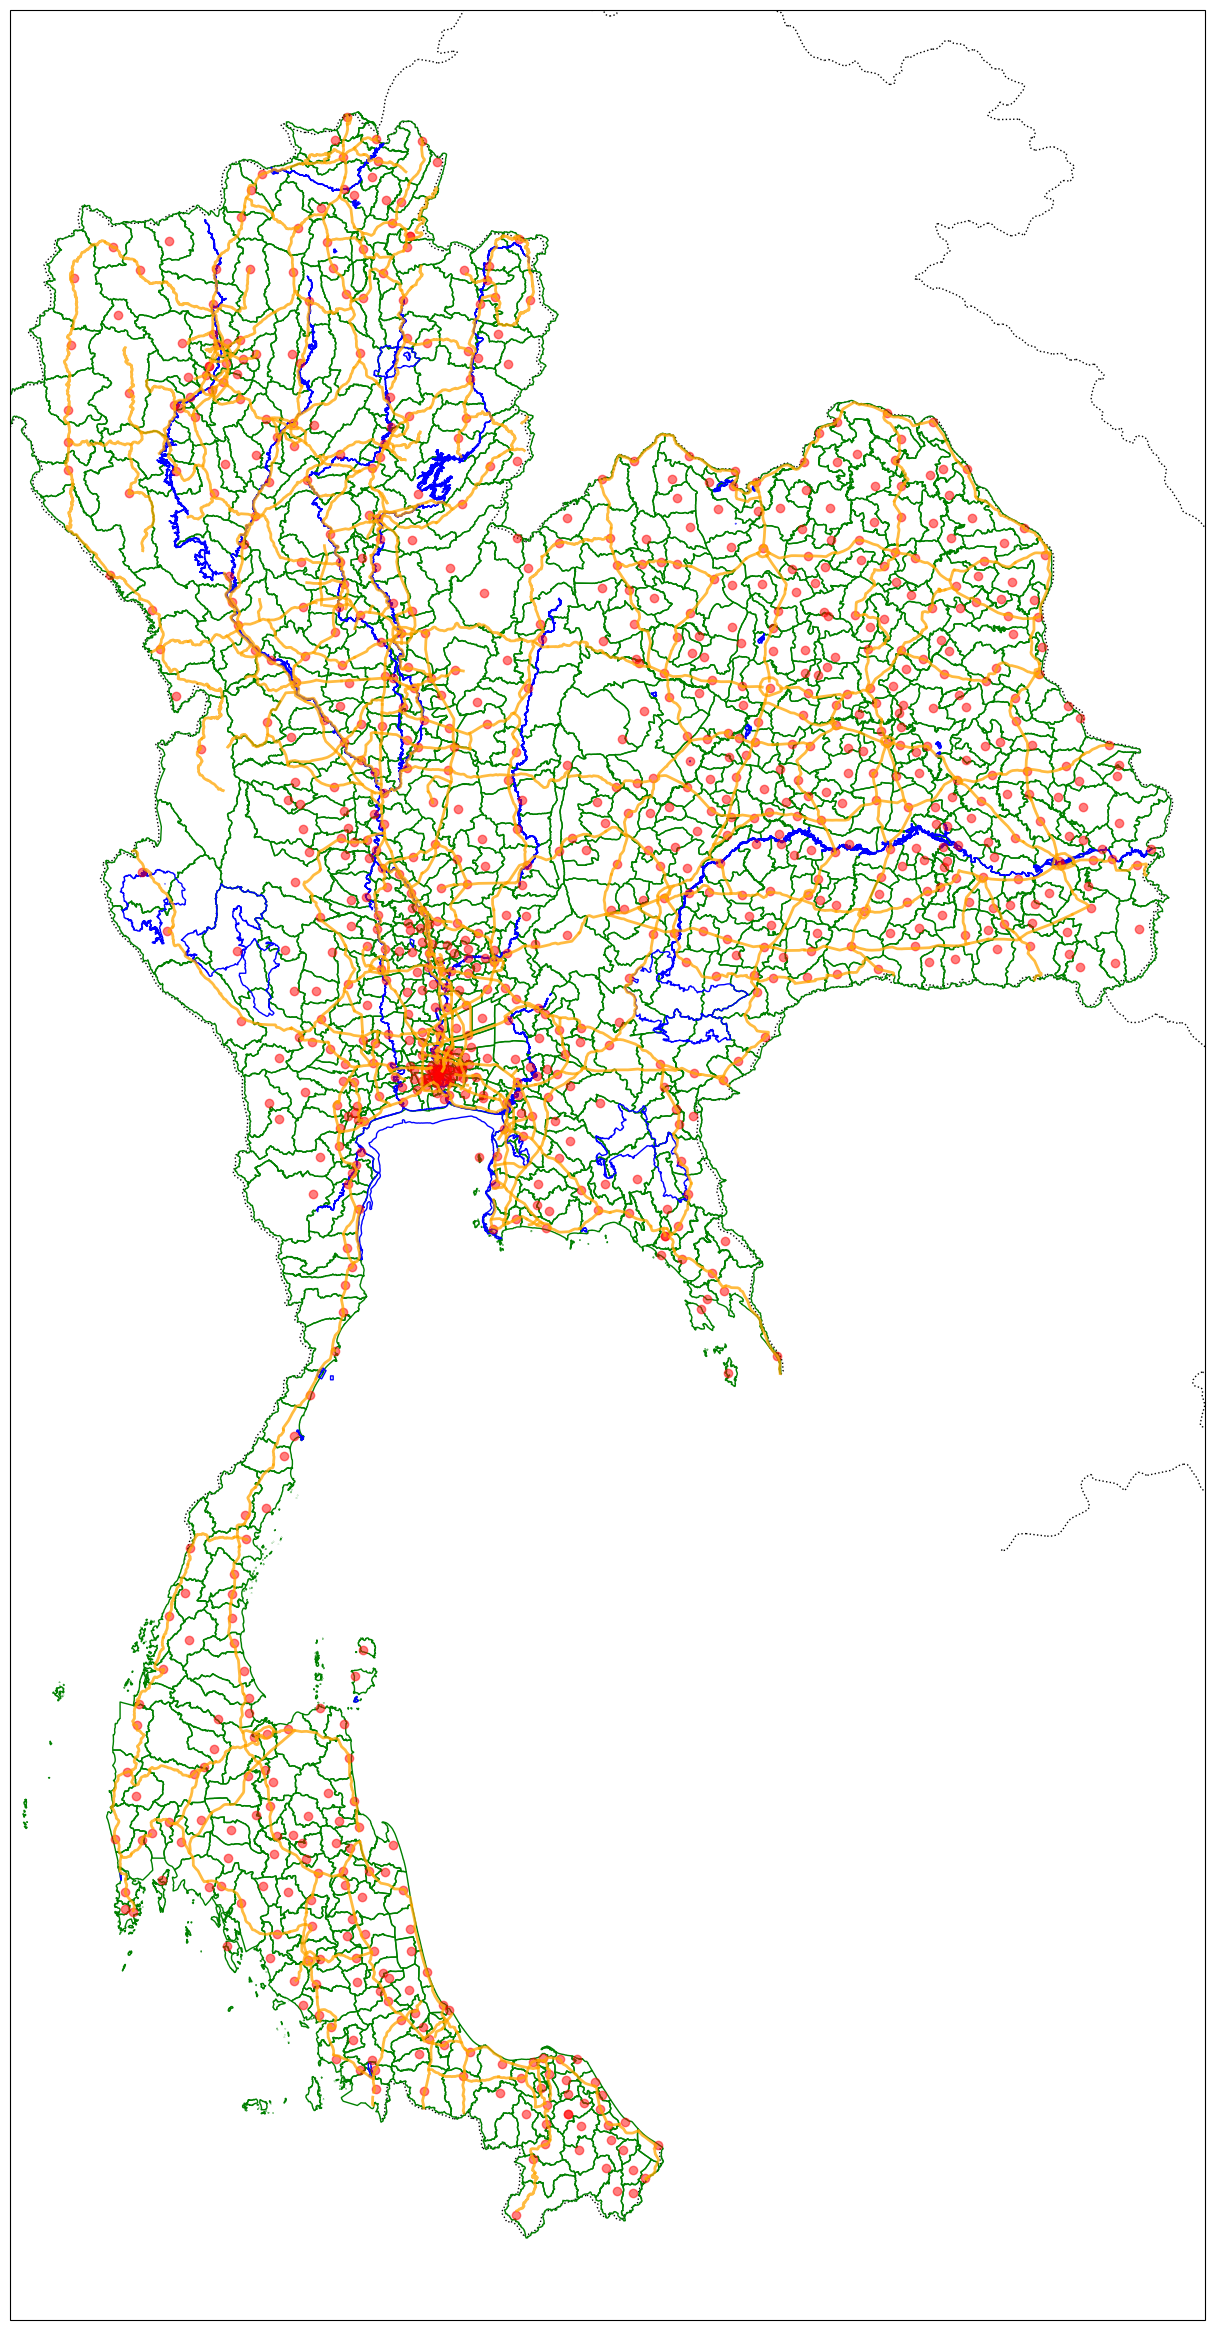

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

df = pd.read_csv("data_gen/allampers.csv")

plt.figure(figsize=(20, 30))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1) 
ax.add_geometries(central['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
ax.add_geometries(east['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
ax.add_geometries(north['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
ax.add_geometries(south['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
ax.add_geometries(northeast['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
ax.add_geometries(west['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')

for i in range(len(df)):
    lat = df.iloc[i]["Lat"]
    lon = df.iloc[i]["Lon"]
    ax.plot(lon, lat, 'o', color='red', alpha=0.5)  # Plot centroid
    # ax.text(lon, lat, str(i+1), ha="right", va="bottom", fontsize=12, fontweight='bold')

### RIVER ###
rivers = gpd.read_file("data_base/road/2022-08-17-filter.geojson")
rivers = rivers.to_crs(epsg=4326)

for i in range(len(rivers)):
    ax.add_geometries(rivers.iloc[i]['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='blue')
    import geopandas as gpd

### ROAD ###
DATA_FOLDER = "data_base/road/"

file_paths_list = [
    "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
    "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
    "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
    "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
    "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
    "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
]

for file_path in file_paths_list:
    color = 'orange'
    width = 2
    alpha = 0.75 

    data = gpd.read_file(DATA_FOLDER+file_path)
    for row_number in range(len(data['name'])):
        row_name = data['name'][row_number]
        row_geometry =  data['geometry'][row_number]
        coordinates = list(row_geometry.coords)
        x = [a for (a,b) in coordinates]
        y = [b for (a,b) in coordinates]
 
        ax.plot(x, y, color=color, alpha=alpha, linewidth=width)

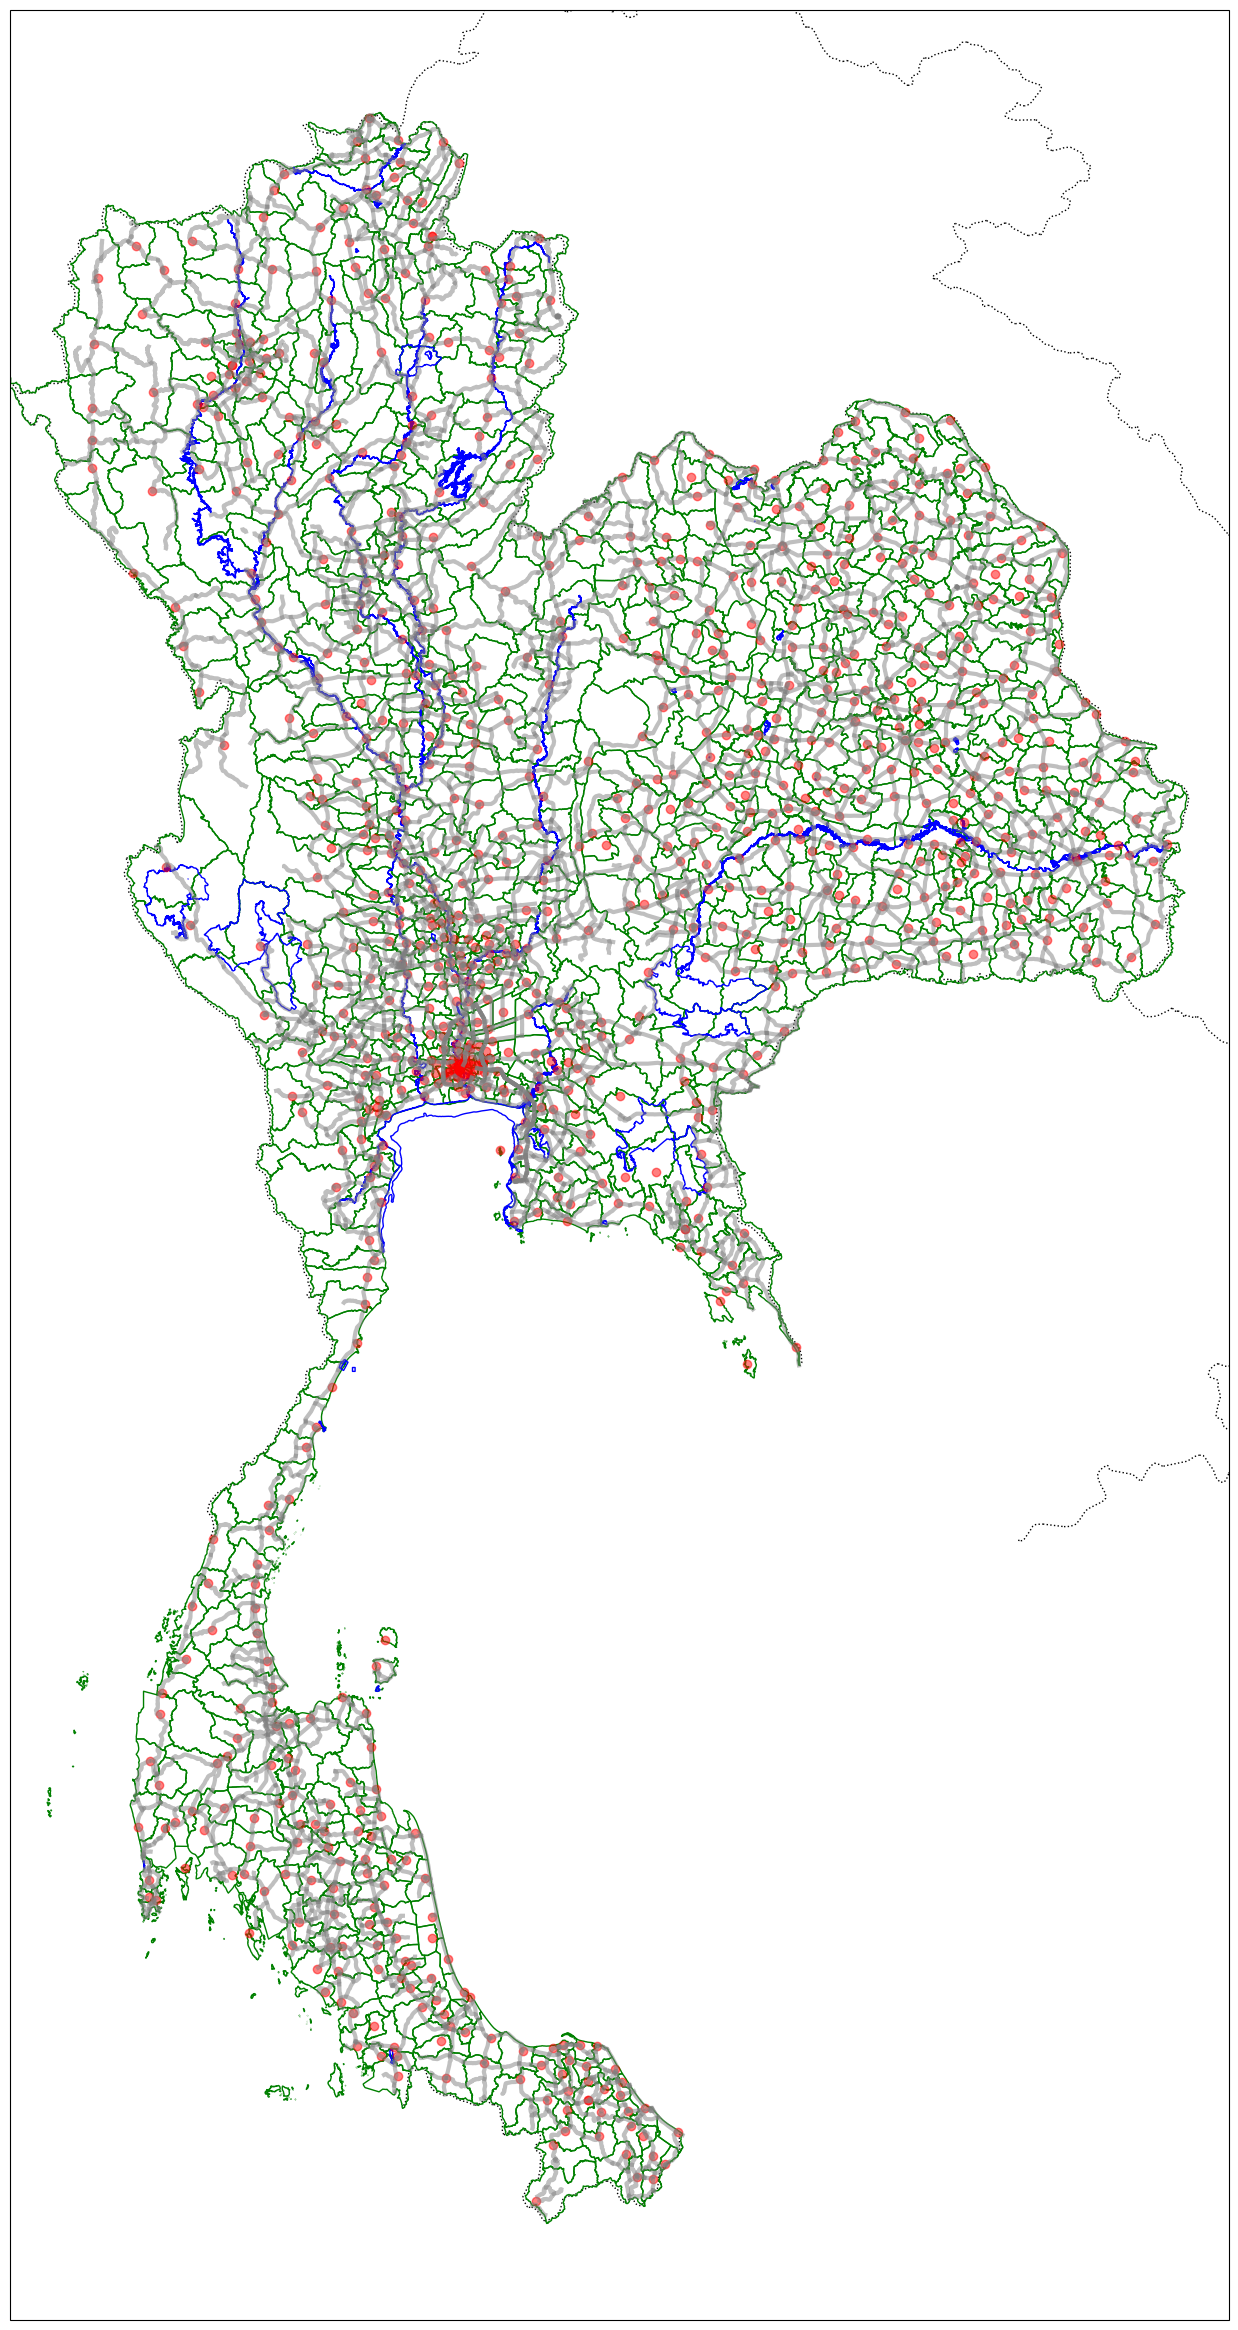

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd

# Load data
df = pd.read_csv("data_gen/allampers.csv")
rivers = gpd.read_file("data_base/road/2022-08-17-filter.geojson").to_crs(epsg=4326)

# Define map appearance
plt.figure(figsize=(20, 30))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1) 

# Define colors and widths for clarity and consistency
region_edge_color = 'green'
river_color = 'blue'
road_color = 'grey'
road_width = 3
road_alpha = 0.5

# Add regional geometries (assuming 'central', 'east', etc. are defined)
regions = [central, east, north, south, northeast, west]
for region in regions:
    ax.add_geometries(region['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=region_edge_color)

# Plot centroids
for lat, lon in zip(df['Lat'], df['Lon']):
    ax.plot(lon, lat, 'o', color='red', alpha=0.5)

# Add river geometries
ax.add_geometries(rivers['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=river_color)

# Define road file paths
DATA_FOLDER = "data_base/road/"
file_paths_list = [
    "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
    "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
    "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
    "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
    "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
    "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
]

# Add road data
for file_path in file_paths_list:
    roads = gpd.read_file(DATA_FOLDER + file_path)
    for x, y in roads.geometry.apply(lambda geom: zip(*geom.coords)):
        ax.plot(x, y, color=road_color, alpha=road_alpha, linewidth=road_width)

plt.show()


/Users/worawittepsan/Library/Python/3.9/lib/python/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/worawittepsan/Library/Python/3.9/lib/python/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


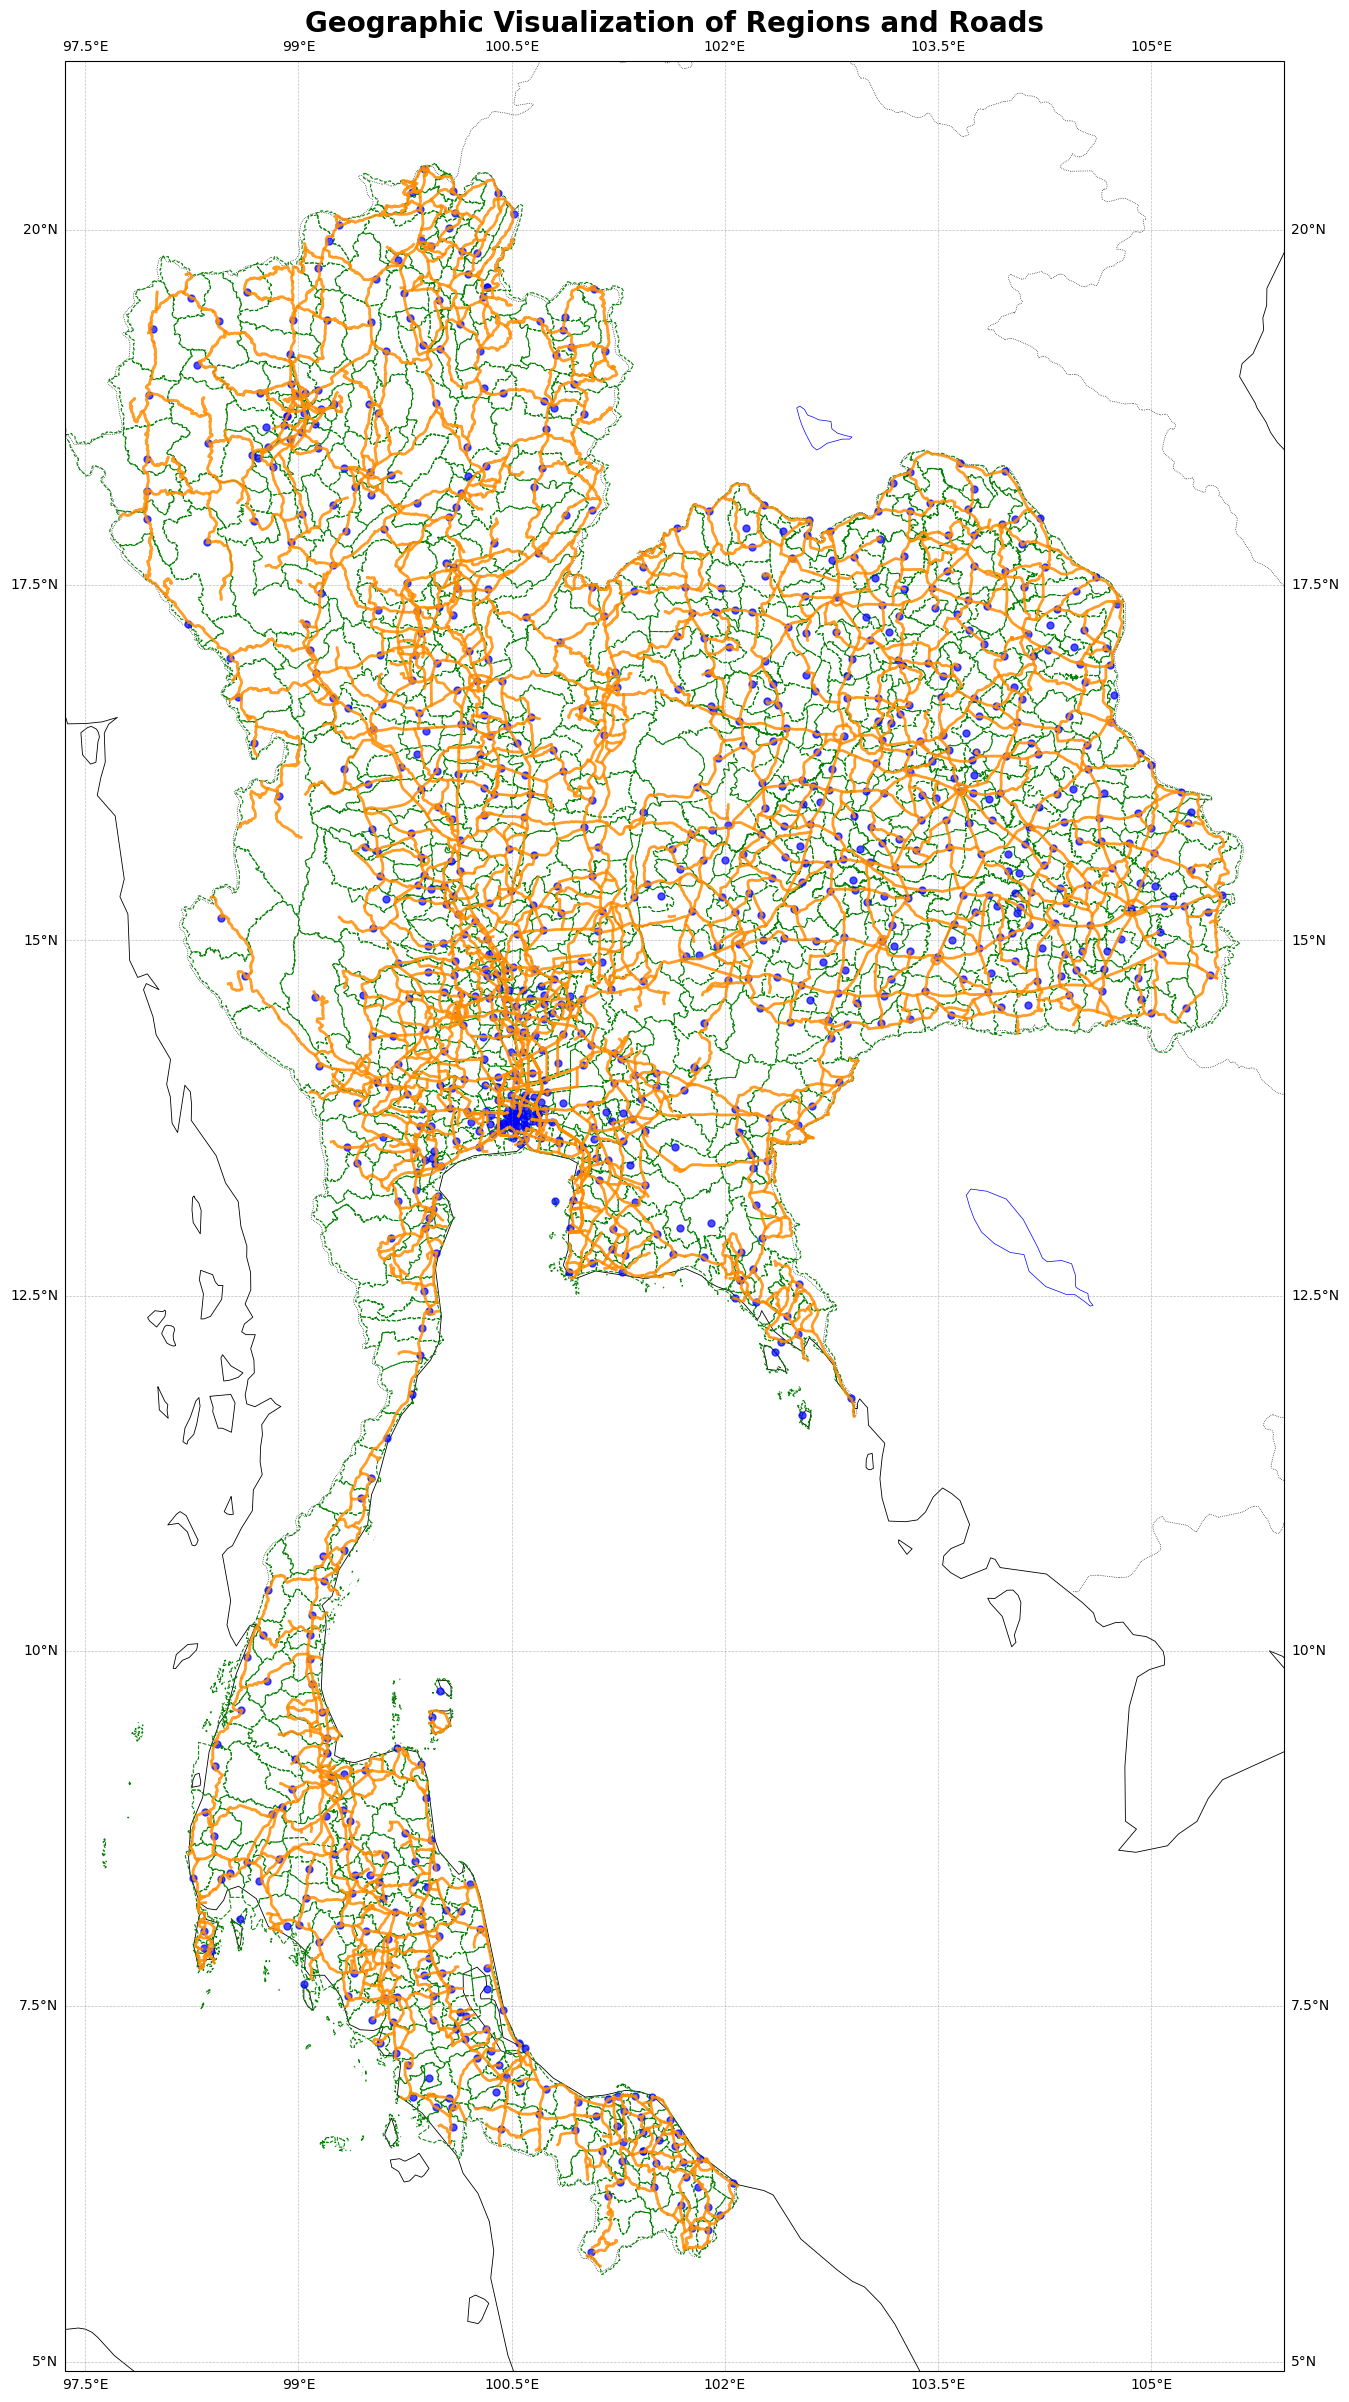

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd

# Load data
df = pd.read_csv("data_gen/allampers.csv")

# Create figure and axes
plt.figure(figsize=(20, 30))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add geographic features with modern styles
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='blue', facecolor='none', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Define regions and style settings
regions = [central, east, north, south, northeast, west]
region_color = 'green'
region_linewidth = 0.75
region_style = '--'

# Add regional geometries
for region in regions:
    ax.add_geometries(region['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=region_color, linestyle=region_style, linewidth=region_linewidth)

# Plot centroids with annotations
for i, row in df.iterrows():
    ax.plot(row['Lon'], row['Lat'], 'o', color='blue', markersize=5, alpha=0.7)

# Roads from GeoJSON files
data_folder = "data_base/road/"
file_paths_list = [
    "thaanghlwng-lamdabesnthaangthii-1-500.geojson",
    "thaanghlwng-lamdabesnthaangthii-501-1000.geojson",
    "thaanghlwng-lamdabesnthaangthii-1001-1500.geojson",
    "thaanghlwng-lamdabesnthaangthii-1501-2000.geojson",
    "thaanghlwng-lamdabesnthaangthii-2001-2500.geojson",
    "thaanghlwng-lamdabesnthaangthii-2501-epntnaip.geojson",
]

# Style settings for roads
road_color = 'darkorange'
road_width = 2
road_alpha = 0.85

# Add road geometries
for file_path in file_paths_list:
    data = gpd.read_file(data_folder + file_path)
    for geom in data['geometry']:
        x, y = geom.xy
        ax.plot(x, y, color=road_color, linewidth=road_width, alpha=road_alpha)

# Grid, labels, and title
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
plt.title("Geographic Visualization of Regions and Roads", fontsize=20, fontweight='bold')

# Display the map
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Assuming THAI_PROVINCES_ENG is a predefined dictionary mapping Thai province names to their English counterparts

# Load the geojson files
provinces = gpd.read_file('./data/query.geojson')
north = gpd.read_file('./data/query-4.geojson')
df = pd.read_csv("../Longan/data/longan_provinces_update.csv")
positions = {i: (df.loc[i, 'lon'], df.loc[i, 'lat']) for i in range(len(df))}

# Define appearance settings
fillopa = 0.7  # Increased opacity for better visibility
opa = 0.5
color_fill = '#74c476'  # A softer green color for fill
border_color = '#31a354'  # A darker shade for the border for contrast
highlight_color = '#de2d26'  # A vibrant color for highlighting specific elements
weight_line = 0.5  # Thinner line for a refined look

# Plot setup
fig, ax = plt.subplots(figsize=(15, 15))

# Plotting the north dataset with improved loop
north.loc[north['pv_tn'].isin(['เชียงใหม่', 'เชียงราย', 'ลำพูน', 'ลำปาง', 'พะเยา', 'แพร่', 'น่าน', 'แม่ฮ่องสอน'])].plot(ax=ax, color=color_fill, alpha=fillopa, edgecolor=border_color, linewidth=1)

# Plot district centroids with clear labels
for i, row in df.iterrows():
    ax.plot(row['lon'], row['lat'], 'o', color='blue', alpha=opa)  # Plot centroid
    ax.text(row['lon'], row['lat'], str(i+1), ha="right", va="bottom", fontsize=12, fontweight='bold')

# Highlighting selected province borders more efficiently
provinces[provinces['pv_tn'].isin(['เชียงใหม่', 'เชียงราย', 'ลำพูน', 'ลำปาง', 'พะเยา', 'แพร่', 'น่าน', 'แม่ฮ่องสอน'])].boundary.plot(ax=ax, color=highlight_color, linewidth=2)

# Label provinces in English for clarity
for _, row in provinces.iterrows():
    if row['pv_tn'] in THAI_PROVINCES_ENG:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, THAI_PROVINCES_ENG[row['pv_tn']], ha="center", va="center", fontsize=14, color='black', fontweight='bold')

# Enhancements for an academic presentation
ax.set_title('The Focus Area of Upper Northern Thailand', fontsize=18, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax.tick_params(labelsize=12)  # Adjust tick label size for clarity

plt.show()


In [38]:
all_amperboundaries[('พระนคร', 'กรุงเทพมหานคร')]['centroid'].xy[0][0]
all_amperboundaries[('พระนคร', 'กรุงเทพมหานคร')]['centroid'].xy[1][0]

13.755425619069753

In [ ]:
positions = dict()
for amper_tuple in allampers: 
    lat = all_amperboundaries[amper_tuple]['centroid'].xy[0][0]
    lon = all_amperboundaries[amper_tuple]['centroid'].xy[1][0]    
    positions[DICT_amper2int[amper_tuple]]  = (lat, lon)

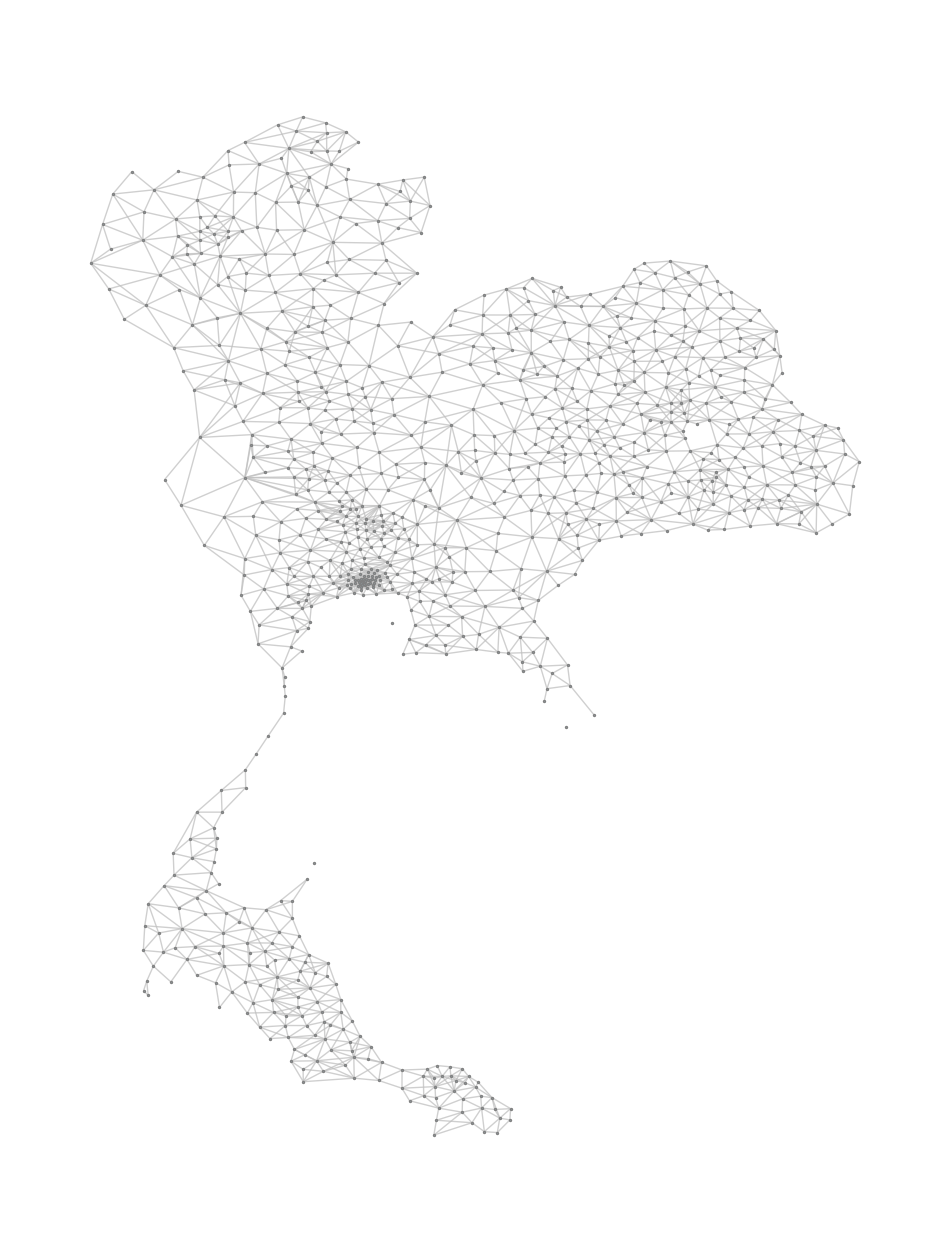

In [45]:
### DISTRICT BOUNDARY ###
csvfiles_path = "data_gen_adjacency_districts/"
csvfiles = os.listdir(csvfiles_path)

# csvfiles = csvfiles[0:2]

A = np.zeros([len(allampers),len(allampers)])

for csvfile in csvfiles:
    csvfile_path = csvfiles_path+csvfile
    df = pd.read_csv(csvfile_path)
    N = len(df)
    for i in range(N):
        amper1_tuple = ast.literal_eval(df.iloc[i]["Amper1"])
        amper2_tuple = ast.literal_eval(df.iloc[i]["Amper2"])

        amper1_index = DICT_amper2int[amper1_tuple]
        amper2_index = DICT_amper2int[amper2_tuple]

        
        A[amper1_index, amper2_index] = 1

G = nx.from_numpy_array(A)

nx.draw_networkx_nodes(G, positions, node_color='lightblue', node_size=2, edgecolors='gray', linewidths=1)
nx.draw_networkx_edges(G, positions, alpha=0.75, edge_color='silver', width =1)
# nx.draw_networkx_labels(G, positions, labels=labels, font_size=8, font_family='sans-serif')

# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='blue', node_size=800, font_size=15)
# plt.show()

plt.axis('off')  # Removes the axis for a cleaner look
plt.gcf().set_size_inches(12, 16)  # Adjust the figure size if necessary for better visibility
 
plt.show()

In [46]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[amper]+1 for amper in allampers], 
    'district': allampers
}) 

centralities = nx.degree_centrality(G)
centrality_list = [value for value in centralities.values()]

df['degree'] = centrality_list

df.to_csv("usecases/centrality_degree.csv", encoding='utf-8-sig')

In [47]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[amper]+1 for amper in allampers], 
    'district': allampers
}) 

centralities = nx.eigenvector_centrality(G, weight='weight', max_iter=10000)
centrality_list = [value for value in centralities.values()]

df['degree'] = centrality_list

df.to_csv("usecases/eigenvector_centrality.csv", encoding='utf-8-sig')

In [50]:
eig, V = np.linalg.eig(A) 
max_eig=max(eig)
alpha0 = 1/(max_eig) 

alphas=np.linspace(0, alpha0, 100)

G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[amper]+1 for amper in allampers], 
    'district': allampers
}) 
alpha = alphas[1]

centralities =  nx.katz_centrality(G, weight= 'weight', alpha = alpha, max_iter = 100000)
centrality_list = [value for value in centralities.values()]

df['degree'] = centrality_list

df.to_csv("usecases/katz_centrality_numpy.csv", encoding='utf-8-sig')

In [ ]:
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

sorted(map(sorted, next_level_communities))

IndexError: list index out of range

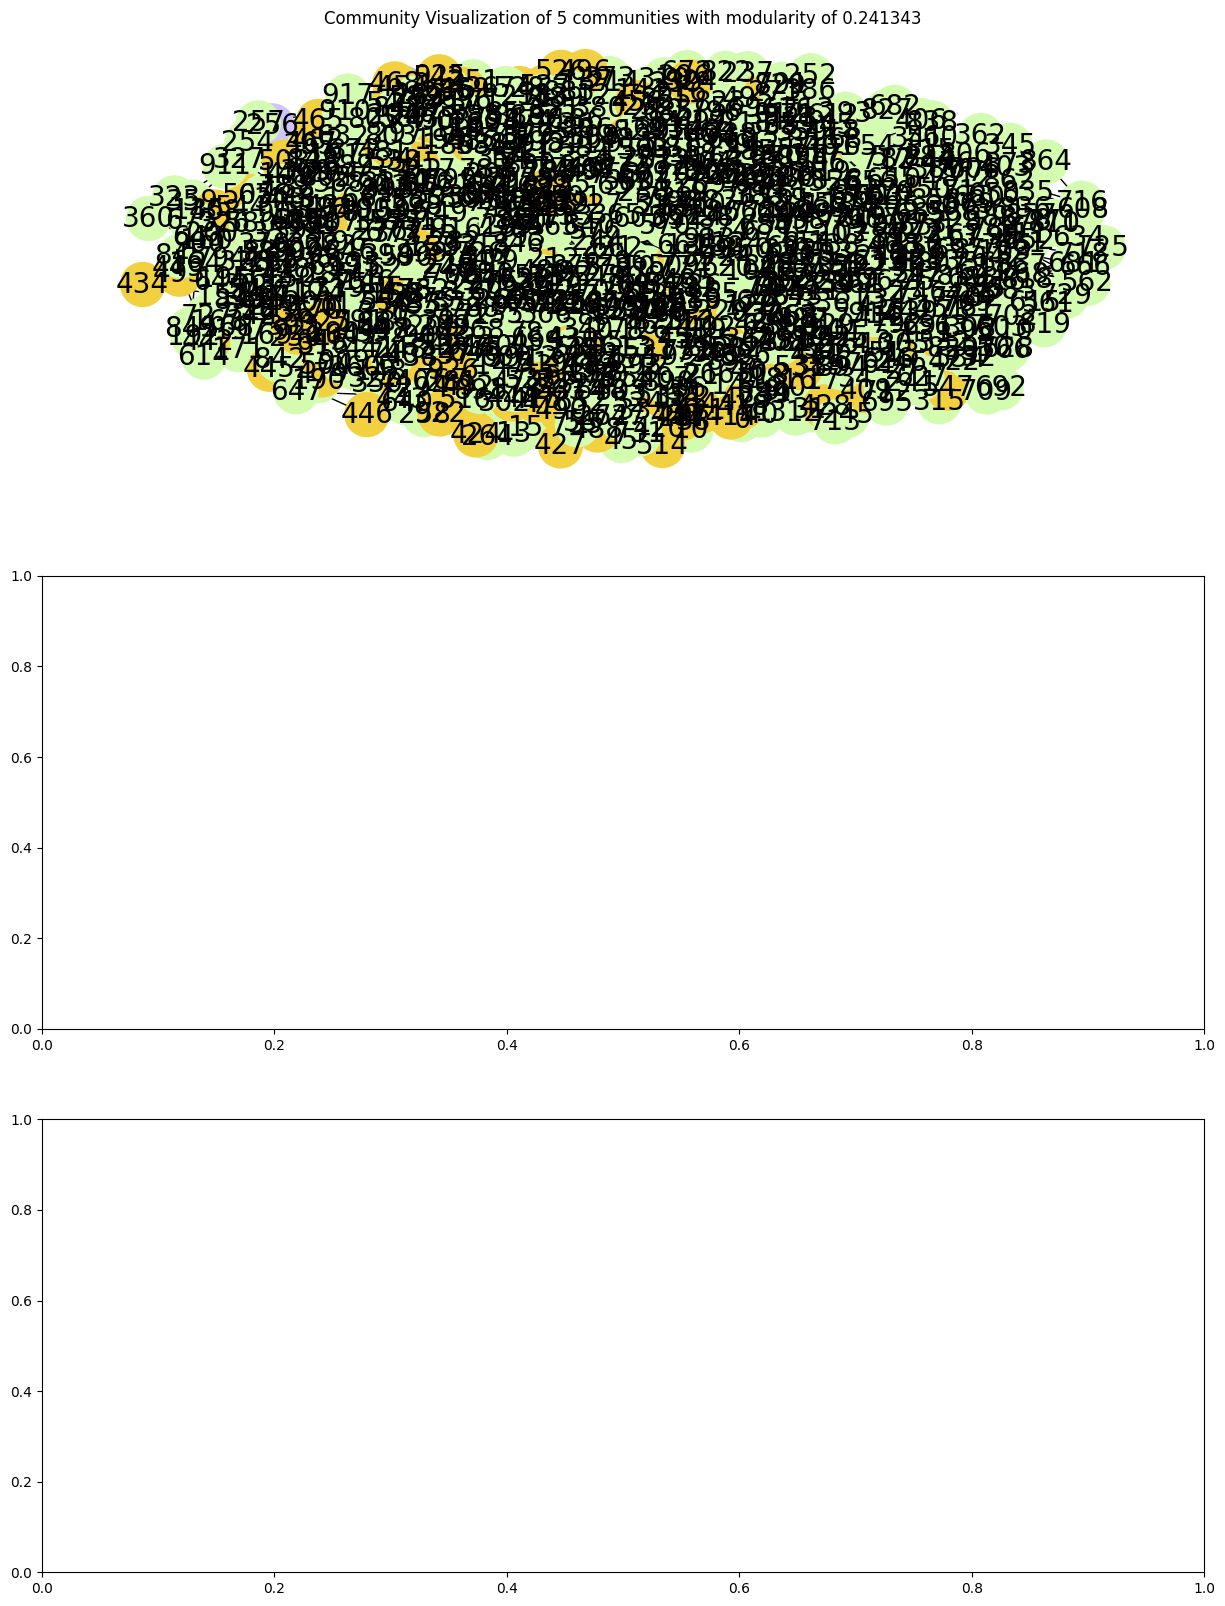

In [54]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load karate graph and find communities using Girvan-Newman
# G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=positions,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )

fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()